<a href="https://colab.research.google.com/github/PEIRONGKANG/DM2024-Lab1-Master/blob/main/LAB2homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab2 Master

In [21]:
import pandas as pd
import json
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 加載數據
data_identification = pd.read_csv("/content/data_identification.csv")
emotion = pd.read_csv("/content/emotion.csv")

# 加載 tweets 數據並轉換為 DataFrame
with open("/content/tweets_DM.json", "r") as file:
    tweets = [json.loads(line) for line in file]
tweets_df = pd.json_normalize([tweet['_source']['tweet'] for tweet in tweets])

# 合並數據集
merged_data = data_identification.merge(tweets_df, on='tweet_id', how='left')
merged_data = merged_data.merge(emotion, on='tweet_id', how='left')

# 分離訓練和測試集
train_df = merged_data[merged_data['identification'] == 'train']
test_df = merged_data[merged_data['identification'] == 'test']


將文本轉化為 TF-IDF 向量，以便模型能夠識別文本特征。

In [23]:
# 重新应用数据预处理
train_df['clean_text'] = train_df['text'].apply(preprocess_text)
test_df['clean_text'] = test_df['text'].apply(preprocess_text)

# 检查是否成功创建 clean_text 列
print(train_df.columns)
print(test_df.columns)

# 確認 clean_text 列存在後，再繼續進行 TF-IDF 向量化處理：
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['clean_text'])
X_test = vectorizer.transform(test_df['clean_text'])


<ipython-input-23-a10d38d316a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['clean_text'] = train_df['text'].apply(preprocess_text)


Index(['tweet_id', 'identification', 'hashtags', 'text', 'emotion',
       'clean_text'],
      dtype='object')
Index(['tweet_id', 'identification', 'hashtags', 'text', 'emotion',
       'clean_text'],
      dtype='object')


<ipython-input-23-a10d38d316a7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['clean_text'] = test_df['text'].apply(preprocess_text)


In [24]:
from sklearn.linear_model import LogisticRegression

# 定義邏輯回歸模型
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
# 預測測試集的情緒標簽
y_pred = model.predict(X_test)
# 創建提交文件
submission = test_df[['tweet_id']].copy()
submission['emotion'] = y_pred
submission.columns = ['id', 'emotion']
submission.to_csv("submission(master).csv", index=False)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


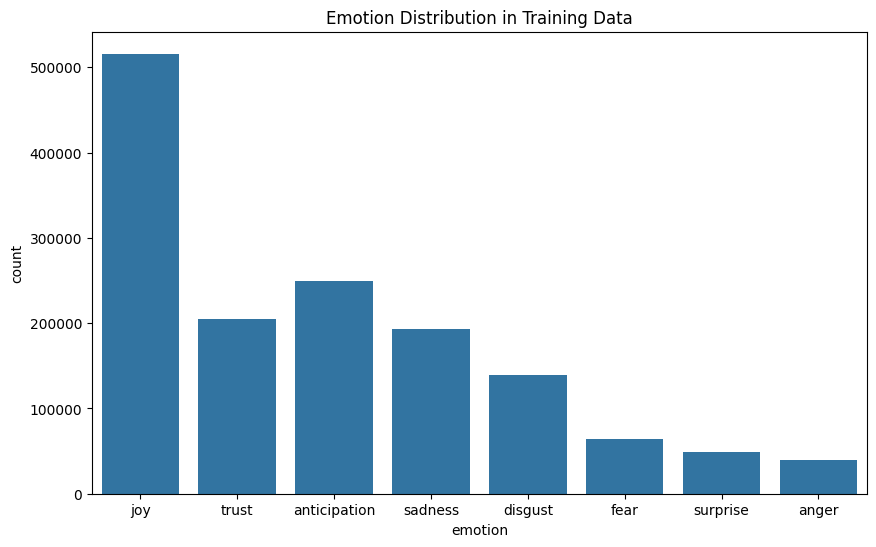

In [25]:
#數據分佈圖
import matplotlib.pyplot as plt
import seaborn as sns

# 各情緒類別分布
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=train_df)
plt.title("Emotion Distribution in Training Data")
plt.show()


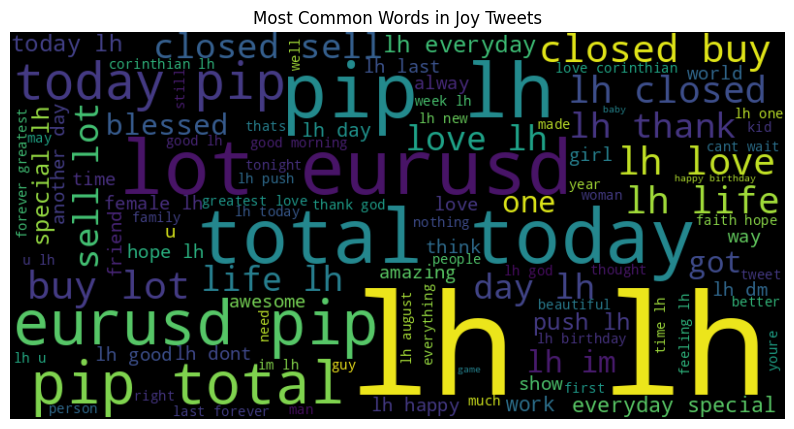

In [26]:
# 詞頻分析
from wordcloud import WordCloud

# 創建詞雲圖（以 'joy' 類別為例）
joy_text = ' '.join(train_df[train_df['emotion'] == 'joy']['clean_text'])
wordcloud = WordCloud(width=800, height=400, max_words=100).generate(joy_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Joy Tweets")
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


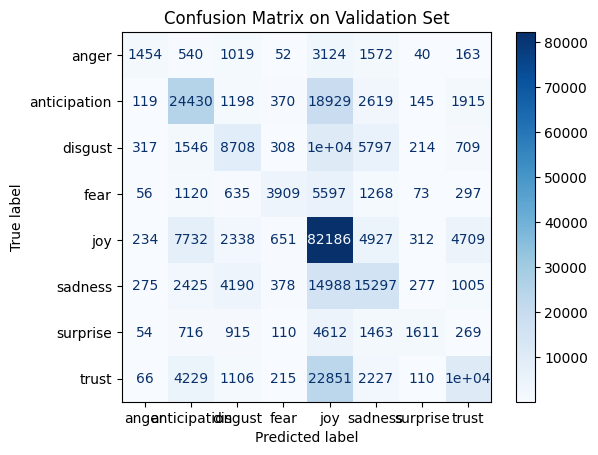

In [28]:
# 模型性能圖表
from sklearn.model_selection import train_test_split

X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=200)
model.fit(X_train_part, y_train_part)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_val_pred = model.predict(X_val)

cm = confusion_matrix(y_val, y_val_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Validation Set")
plt.show()



In [ ]:
# 樹模型
# 僅適用於隨機森林或樹模型
from sklearn.ensemble import RandomForestClassifier

# 使用随机森林模型
forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)

# 获取特征重要性
importances = forest_model.feature_importances_
indices = np.argsort(importances)[-20:]  # 获取最重要的20个特征
plt.figure(figsize=(10, 6))
plt.title("Feature Importances from RandomForest")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [vectorizer.get_feature_names_out()[i] for i in indices])
plt.xlabel("Importance")
plt.show()


# Lab2 Homework

In [1]:
!pip3 install gensim tensorflow keras pandas numpy matplotlib plotly seaborn nltk umap-learn ollama langchain langchain_community langchain_core beautifulsoup4 chromadb gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.0/408.0 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.5/612.5 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 27.4 MB/s eta 